# Optimize a Deep Learning model for mobile deployment with LiteRT

Mobile optimization transforms AI from cloud-dependent services into instant, private, and always-available experiences that work in your pocket without internet connectivity.

> **Overview**: Optimize a computer vision model for mobile deployment using LiteRT's hardware acceleration and configuration options to achieve efficient on-device inference.
> 
> **Scenario**: You work for a photo editing app startup that needs real-time image filters on smartphones. Your production pipeline currently processes only 12 frames/second on mid-range Android devices, but users expect 30+ FPS for smooth real-time effects. You are tasked with optimizing the core model inference from 25 FPS to 60+ FPS to give your production pipeline sufficient headroom for smooth user experience.
> 
> **Goal**: Use LiteRT delegates, threading policies, and precision optimizations to maximize mobile inference performance while managing power consumption trade-offs.
> 
> **Tools**: tensorflow, litert, pillow
> 
> **Estimated Time**: 10 minutes

> _**IMPORTANT SIMULATION NOTE**_: This exercise simulates mobile constraints on desktop hardware. Real mobile performance varies significantly based on chipset architecture, thermal design, and available accelerators (GPU, NPU, Neural Engine).


##  Step 1: Setup

Let's establish your baseline environment and understand mobile deployment constraints.

In [1]:
# # Uncomment to install necessary libraries, then comment out and restart
# ! pip install ai-edge-litert tensorflow pillow

In [2]:
# Import core libraries
import os
import warnings
warnings.filterwarnings("ignore")

from ai_edge_litert.interpreter import Interpreter
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import time
from datetime import datetime
import json

# Create output directory
output_dir = "assets/exercise2"
os.makedirs(output_dir, exist_ok=True)

2025-08-24 14:16:00.561473: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-24 14:16:00.624176: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


> **Should you add the CPU instructions suggested by TensorFlow?** oneDNN custom operations and x86-specific CPU instructions (AVX, FMA, etc.) are used by TensorFlow to accelerate performance on desktop CPU. Since your goal is mobile deployment, these are not applicable. But, consider when optimizing for desktop CPUs.

In [3]:
# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

print("=== MOBILE DEPLOYMENT CONTEXT ===")
print("Target devices: Mid-range Android phones (4-6GB RAM)")
print("CPU cores: 4-8 cores (ARM Cortex-A55/A75)")
print("GPU: Adreno 618/Mali-G72 (limited compute)")
print("Power budget: <2W for sustained inference")
print("Thermal throttling: Kicks in after ~30 seconds of heavy load")
print()

print("Environment setup complete!")

=== MOBILE DEPLOYMENT CONTEXT ===
Target devices: Mid-range Android phones (4-6GB RAM)
CPU cores: 4-8 cores (ARM Cortex-A55/A75)
GPU: Adreno 618/Mali-G72 (limited compute)
Power budget: <2W for sustained inference
Thermal throttling: Kicks in after ~30 seconds of heavy load

Environment setup complete!


> **Mobile deployment reality check**: Unlike desktop/cloud deployment, mobile devices face unique constraints: limited RAM shared across all apps, thermal throttling that reduces performance over time, and battery drain that directly impacts user experience. LiteRT's delegate system addresses these by providing hardware-specific optimizations while maintaining broad device compatibility.

## Step 2: Create dataset and baseline model

For this exercise, we'll create a synthetic dataset that simulates real-world image processing workloads. The model is a pre-trained [MobileNetV2](https://www.tensorflow.org/api_docs/python/tf/keras/applications/MobileNetV2) from TensorFlow Keras.

> **A note on LiteRT cross-framework support**: While you use TensorFlow for your model creation, LiteRT also accepts models from PyTorch and JAX. All convert to the same `.tflite` format for unified mobile deployment. 


In [4]:
def create_synthetic_image_dataset(num_samples=1000, image_size=(224, 224)):
    """
    Create synthetic image dataset for mobile optimization testing
    Simulates photo editing app workload with some realistic image distributions
    """
    
    print("Creating synthetic image dataset...")
    
    # Generate diverse image patterns to test model performance
    images = []
    labels = []
    
    for i in range(num_samples):
        # Create realistic image patterns (gradients, textures, edges)
        if i % 3 == 0:
            # Gradient pattern (common in photos)
            img = np.linspace(0, 255, image_size[0] * image_size[1] * 3)
            img = img.reshape(image_size[0], image_size[1], 3)
        elif i % 3 == 1:
            # Texture pattern (high-frequency content)
            img = np.random.normal(128, 30, (image_size[0], image_size[1], 3))
        else:
            # Mixed pattern (realistic photo simulation)
            base = np.random.uniform(50, 200, (image_size[0], image_size[1], 3))
            noise = np.random.normal(0, 15, (image_size[0], image_size[1], 3))
            img = base + noise
        
        # Normalize to [0, 255] and convert to uint8
        img = np.clip(img, 0, 255).astype(np.uint8)
        images.append(img)
        labels.append(i % 1000)  # 1000 classes for ImageNet simulation
    
    images = np.array(images)
    labels = np.array(labels)
    
    print(f"Dataset created:")
    print(f"Images shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Image data type: {images.dtype}")
    print(f"Memory usage: {images.nbytes / 1024**2:.1f} MB")
    
    return images, labels

def preprocess_for_mobilenet(images):
    """Preprocess images for MobileNetV2 input requirements"""
    
    # Convert to float32 and normalize to [-1, 1] (MobileNetV2 requirement)
    processed = images.astype(np.float32)
    processed = (processed / 127.5) - 1.0
    
    print(f"Preprocessing complete:")
    print(f"Value range: [{processed.min():.2f}, {processed.max():.2f}]")
    print(f"Data type: {processed.dtype}")
    
    return processed

# Create dataset
raw_images, labels = create_synthetic_image_dataset(num_samples=500)
processed_images = preprocess_for_mobilenet(raw_images)

# Create batches for testing different batch sizes
batch_sizes = [1, 4, 8, 16]
test_batches = {}

for batch_size in batch_sizes:
    num_batches = min(20, len(processed_images) // batch_size)
    batch_data = processed_images[:num_batches * batch_size]
    batch_data = batch_data.reshape(num_batches, batch_size, 224, 224, 3)
    test_batches[batch_size] = batch_data
    print(f"Batch size {batch_size}: {batch_data.shape}")

Creating synthetic image dataset...
Dataset created:
Images shape: (500, 224, 224, 3)
Labels shape: (500,)
Image data type: uint8
Memory usage: 71.8 MB
Preprocessing complete:
Value range: [-1.00, 1.00]
Data type: float32
Batch size 1: (20, 1, 224, 224, 3)
Batch size 4: (20, 4, 224, 224, 3)
Batch size 8: (20, 8, 224, 224, 3)
Batch size 16: (20, 16, 224, 224, 3)


> **On using a synthetic dataset**: Real mobile photo processing involves diverse image content - from smooth gradients in sky photos to high-frequency textures in fabric close-ups. your synthetic dataset simulates these patterns at a high-level to support extending the testing to accuracy too (by making sure optimization results generalize across typical user content).

In [5]:
def create_base_mobilenet_model():
    """Create and prepare base MobileNetV2 model for optimization"""
    
    print("Creating base MobileNetV2 model...")
    
    # Load pre-trained MobileNetV2
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(224, 224, 3),
        alpha=1.0,  # Width multiplier
        weights='imagenet',
        include_top=True,
        classifier_activation='softmax'  # Explicit activation for mobile
    )
    
    # Compile for inference
    base_model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Model analysis for mobile deployment
    model_params = base_model.count_params()
    
    print(f"Baseline MobileNetV2 for mobile:")
    print(f"  Parameters: {model_params:,}")
    print(f"  Layers: {len(base_model.layers)}")
    print(f"  Model size (FP32): {model_params * 4 / 1024**2:.1f} MB")
    print(f"  Expected mobile RAM usage: {model_params * 4 * 3 / 1024**2:.1f} MB")  # 3x for activations
    
    return base_model

# Create your base model
base_mobilenet_model = create_base_mobilenet_model()

Creating base MobileNetV2 model...


W0000 00:00:1756044970.195778     670 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Baseline MobileNetV2 for mobile:
  Parameters: 3,538,984
  Layers: 156
  Model size (FP32): 13.5 MB
  Expected mobile RAM usage: 40.5 MB


> **Why is the expected mobile RAM usage higher than the model size?** The model's runtime memory requirements do not only include model weights, but also intermediate activations and input/output buffers. For this example, you use x3 as expected model RAM usage just as a general approximation for this type of model.

## Step 3: Understanding LiteRT delegate architecture

[LiteRT](https://ai.google.dev/edge/litert) enables flexible, cross-platform hardware acceleration for on-device AI inference, allowing models to efficiently run on mobile CPU as well as GPU or other specialized accelerators. 

Hardware accelerations are managed through LiteRT's delegate system. Let's understand how this works before implementing optimizations.

_NOTE: You can also [create your own LiteRT delegate!](https://ai.google.dev/edge/litert/performance/implementing_delegate)_


In [ ]:
def analyze_mobile_litert_ecosystem():
    """
    Comprehensive analysis of LiteRT mobile optimization strategies
    """
    
    print("=== LITERT MOBILE OPTIMIZATION ECOSYSTEM ===")
    print()
    
    # Mobile-specific delegate analysis
    mobile_delegates = [
        ("GPU Delegate", "Android GPU/Metal", 
         "3-5x speedup on compatible ops, FP16 preferred", 
         "High power draw, thermal throttling risk"),
        
        ("XNNPACK Delegate", "Optimized CPU kernels", 
         "2-3x CPU speedup, broad compatibility", 
         "Default choice for mobile CPU optimization"),
        
        ("NNAPI Delegate", "Android ML accelerators", 
         "Automatic vendor hardware (DSP/NPU)", 
         "Device-dependent performance, compatibility issues"),
        
        ("Core ML Delegate", "iOS Neural Engine", 
         "Excellent power efficiency on A12+ chips", 
         "iOS-only, limited operation support"),
        
        ("Qualcomm Delegate", "Snapdragon NPU/DSP", 
         "Ultra-low power AI acceleration", 
         "Requires QNN SDK, device-specific"),
    ]
    
    for delegate, platform, benefits, considerations in mobile_delegates:
        print(f"📱 {delegate}:")
        print(f"   Platform: {platform}")
        print(f"   Benefits: {benefits}")
        print(f"   Mobile considerations: {considerations}")
        print()
    
    print("=== MOBILE OPTIMIZATION STRATEGIES ===")
    
    strategies = [
        ("Threading Optimization", 
         "Balance performance vs thermal throttling",
         "1-2 threads: battery-efficient, 2-4 threads: balanced, 4+ threads: performance"),
        
        ("Precision Optimization", 
         "Reduce memory bandwidth and storage",
         "FP16: 2x compression, INT8: 4x compression, minimal accuracy loss"),
        
        ("Operator Fusion", 
         "Reduce memory traffic between operations",  
         "Conv+BatchNorm+ReLU → single fused operation"),
        
        ("Memory Layout", 
         "Optimize for mobile cache hierarchies",
         "NHWC format preferred for mobile ARM processors"),
    ]
    
    for strategy, purpose, implementation in strategies:
        print(f"⚡ {strategy}:")
        print(f"   Purpose: {purpose}")
        print(f"   Implementation: {implementation}")
        print()
    
    print("=== MOBILE DEPLOYMENT DECISION TREE ===")
    print("1. Start with XNNPACK delegate (universal CPU optimization)")
    print("2. Add FP16 quantization (2x size reduction, broad compatibility)")  
    print("3. Test GPU delegate (if target devices support it)")
    print("4. Consider INT8 quantization (if accuracy loss acceptable)")
    print("5. Enable specialized delegates (NNAPI/NPU for specific vendors)")
    
    return ["XNNPACK", "FP16_Quantization", "GPU_Fallback", "Thermal_Aware"]

# Analyze mobile optimization landscape
optimization_strategies = analyze_mobile_litert_ecosystem()

=== LITERT MOBILE OPTIMIZATION ECOSYSTEM ===

📱 GPU Delegate:
   Platform: Android GPU/Metal
   Benefits: 3-5x speedup on compatible ops, FP16 preferred
   Mobile considerations: High power draw, thermal throttling risk

📱 XNNPACK Delegate:
   Platform: Optimized CPU kernels
   Benefits: 2-3x CPU speedup, broad compatibility
   Mobile considerations: Default choice for mobile CPU optimization

📱 NNAPI Delegate:
   Platform: Android ML accelerators
   Benefits: Automatic vendor hardware (DSP/NPU)
   Mobile considerations: Device-dependent performance, compatibility issues

📱 Core ML Delegate:
   Platform: iOS Neural Engine
   Benefits: Excellent power efficiency on A12+ chips
   Mobile considerations: iOS-only, limited operation support

📱 Qualcomm Delegate:
   Platform: Snapdragon NPU/DSP
   Benefits: Ultra-low power AI acceleration
   Mobile considerations: Requires QNN SDK, device-specific

=== MOBILE OPTIMIZATION STRATEGIES ===
⚡ Threading Optimization:
   Purpose: Balance performan

> **LiteRT delegates work in a hierarchical way**: LiteRT's delegates system automatically partitions your model so computationally intensive operations run on specialized processors (GPU, NPU, Neural Engine) while maintaining compatibility through CPU fallback. 
> 
> This means a single LiteRT model can achieve 5x speedups on flagship devices with dedicated AI chips while still running efficiently on budget phones with basic ARM processors.

## Step 4: Export MobileNetV2 with different LiteRT optimizations

Let's implement MobileNetV2 conversion with various LiteRT hardware optimizations to create four **_incremental_** deployment configurations:

1. **Baseline**: No optimization - measures raw model performance for comparison
2. **CPU Optimized (XNNPack)**: Performs operator fusion for balanced CPU performance
3. **FP16 Precision (XNNPack)**: Sets half-precision for 50% smaller app downloads and faster loading
4. **Multi-thread Performance (XNNPack)**: Explores higher threading levels for latency-sensitive app

Each configuration comes with its own trade-off on performance, app size, battery life, and device compatibility.

> **How to set up LiteRT delegates:** This tutorial only uses XNNPack (CPU delegate), which is already bundled in TensorFlow Lite and doesn’t require extra files. Other delegates you may explore (platform dependent):
> 
> - GPU delegate (libtensorflowlite_gpu_delegate.so): For mobile GPUs
> 
> - NNAPI delegate (Android only): Maps ops to hardware accelerators
> 
> - Core ML delegate (iOS only): Maps ops to Apple’s Neural Engine
> 
> Each requires a specific `.so` library to be loaded as an app dependency. _See [LiteRT Delegates](https://ai.google.dev/edge/litert/performance/delegates) for more details._
> 
> These delegates are not required for your exercise, but you’ll see **TODOs** in the code where you could import and load them if available.

In [ ]:
# TODO: Define mobile optimization configurations focused on hardware acceleration
# HINT: Add the 3 missing configurations outlined in the section intro above to test different mobile hardware acceleration scenarios
# Find details on the configuration parameters in the `convert_with_optimization()` function definition.
# BONUS: Why not try other configurations too?
optimization_configs = [
    {
        'name': 'baseline_fp32',
        'precision': 'fp32',
        'delegates': [],
        'num_threads': 1
    },
    # Add your code here
    {
        'name': 'fp32_xnnpack',
        'precision': 'fp32', 
        'delegates': ['xnnpack'],
        'num_threads': 1
    },
    {
        'name': 'fp16_xnnpack',
        'precision': 'fp16',
        'delegates': ['xnnpack'],
        'num_threads': 1
    },
    {
        'name': 'fp16_xnnpack_multithread2',
        'precision': 'fp16',
        'delegates': ['xnnpack'],
        'num_threads': 2
    },
    {
        'name': 'fp16_xnnpack_multithread4',
        'precision': 'fp16',
        'delegates': ['xnnpack'],
        'num_threads': 4
    }  
]

In [ ]:
class MobileLiteRTOptimizer:
    """
    MobileNetV2 optimization using LiteRT
    Tests different delegates, threading, and precision configurations
    """
    
    def __init__(self, base_model):
        self.base_model = base_model
        self.optimized_models = {}
    
    def convert_with_optimization(self, optimization_config):
        """
        Convert model to LiteRT with specific optimization configuration
        
        Args:
            optimization_config (dict): Configuration including:
                - precision: 'fp32', 'fp16'
                - delegates: ['xnnpack', 'gpu', ...] - [Full list at https://ai.google.dev/edge/litert/performance/delegates]
                - num_threads: int
        """
        
        config_name = optimization_config['name']
        print(f"\nConverting model with {config_name} optimization...")
        
        # TODO: Create LiteRT converter (conversion pipeline)
        # HINT: Instantiate the converter object with the model
        # Reference: https://ai.google.dev/edge/api/tflite/python/tf/lite/TFLiteConverter
        converter = tf.lite.TFLiteConverter.from_keras_model(self.base_model)  # Add your code here
        
        # TODO: Configure precision optimizations
        # HINT: Look at how the Optimize and TargetSpec options for the converter let you model expected precisions
        # In practice, you'd typically support 'int8' too for quantization, but model compression is out-of-scope for this exercise
        # Reference: https://ai.google.dev/edge/api/tflite/python/tf/lite/TFLiteConverter
        
        if optimization_config['precision'] == 'fp16':
            # Add your code here
            converter.optimizations = [tf.lite.Optimize.DEFAULT]
            converter.target_spec.supported_types = [tf.float16]
        else:  # fp32
            # Add your code here
            # No optimization for baseline comparison
            pass
        
        # Convert model
        try:
            litert_model = converter.convert()
            model_size = len(litert_model)
            
            print(f"✓ Conversion successful:")
            print(f"  Model size: {model_size / 1024**2:.1f} MB")
            print(f"  Precision: {optimization_config['precision']}")
            
            self.optimized_models[config_name] = {
                'model_content': litert_model,
                'size_mb': model_size / 1024**2,
                'config': optimization_config
            }
            
            return litert_model
            
        except Exception as e:
            print(f"✗ Conversion failed: {e}")
            return None
    
    def create_litert_interpreter(self, model_content, config):
        """
        Create LiteRT interpreter with specified configuration and delegates
        """
        try:
            experimental_delegates = []
            
            # TODO: Load the delegate
            # HINTS: Since xnnpack is bundled with tensorflow, you don't need to import it
            # IMPORTANT: For other delegates, you need to define the delegate variable as the path to the delegate library: "/path/to/libtensorflowlite_[...].so"
            # Reference: https://ai.google.dev/edge/api/tflite/python/tf/lite/experimental/load_delegate
            for delegate_name in config.get('delegates', []):
                if delegate_name != 'xnnpack':
                    # Add your code here
                    delegate = tf.lite.experimental.load_delegate(config['delegate'])
                    experimental_delegates.append(delegate)

            print(f"experimental delegates: {experimental_delegates}")

            # TODO: Create base LiteRT interpreter with threading configuration
            # Reference: https://ai.google.dev/edge/api/tflite/python/tf/lite/Interpreter
            interpreter = Interpreter(
                model_content=model_content,
                experimental_delegates=experimental_delegates or None,
                num_threads=config.get('num_threads', 1)
            )  # Add your code here
            
            # Allocate tensors for inference
            interpreter.allocate_tensors()
            
            print(f"✓ LiteRT interpreter created:")
            print(f"  Threading: {config.get('num_threads', 1)} threads")
            print(f"  Target hardware: {config.get('delegate')}")
            print(f"  Precision: {config.get('precision', 'fp32')}")
            
            return interpreter
            
        except Exception as e:
            print(f"✗ Interpreter creation failed: {e}")
            return None

# Initialize optimizer and create base model
optimizer = MobileLiteRTOptimizer(base_mobilenet_model)

# Convert models with different optimizations
for config in optimization_configs:
    optimizer.convert_with_optimization(config)

print(f"\nOptimization complete! Created {len(optimizer.optimized_models)} model variants.")


Converting model with baseline_fp32 optimization...
INFO:tensorflow:Assets written to: /tmp/tmp74zqm1xz/assets


INFO:tensorflow:Assets written to: /tmp/tmp74zqm1xz/assets


Saved artifact at '/tmp/tmp74zqm1xz'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1000), dtype=tf.float32, name=None)
Captures:
  139889155745824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139889155747584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139889155747936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139889155745648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139889155746880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139889155751280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139889155982960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139889155985600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139889155981552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139889155984192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13988915573

W0000 00:00:1756044977.944318     670 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1756044977.944343     670 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-08-24 14:16:17.944752: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp74zqm1xz
2025-08-24 14:16:17.957122: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-08-24 14:16:17.957137: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp74zqm1xz
I0000 00:00:1756044978.058783     670 mlir_graph_optimization_pass.cc:437] MLIR V1 optimization pass is not enabled
2025-08-24 14:16:18.085668: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-08-24 14:16:18.923870: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmp74zqm1xz
2025-08-24 14:16:19.115875: I tensorflow/cc/saved_model/loader.cc:471] SavedModel 

✓ Conversion successful:
  Model size: 13.3 MB
  Precision: fp32

Converting model with fp32_xnnpack optimization...
INFO:tensorflow:Assets written to: /tmp/tmpspvg2ar9/assets


INFO:tensorflow:Assets written to: /tmp/tmpspvg2ar9/assets


Saved artifact at '/tmp/tmpspvg2ar9'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1000), dtype=tf.float32, name=None)
Captures:
  139889155745824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139889155747584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139889155747936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139889155745648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139889155746880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139889155751280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139889155982960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139889155985600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139889155981552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139889155984192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13988915573

W0000 00:00:1756044986.448102     670 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1756044986.448135     670 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-08-24 14:16:26.448346: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpspvg2ar9
2025-08-24 14:16:26.463549: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-08-24 14:16:26.463571: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpspvg2ar9
2025-08-24 14:16:26.604024: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-08-24 14:16:27.418239: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpspvg2ar9
2025-08-24 14:16:27.608282: I tensorflow/cc/saved_model/loader.cc:471] SavedModel load for tags { serve }; Status: success: OK. Took 1159940 microseconds.


✓ Conversion successful:
  Model size: 13.3 MB
  Precision: fp32

Converting model with fp16_xnnpack optimization...
INFO:tensorflow:Assets written to: /tmp/tmpe1le4si6/assets


INFO:tensorflow:Assets written to: /tmp/tmpe1le4si6/assets


Saved artifact at '/tmp/tmpe1le4si6'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1000), dtype=tf.float32, name=None)
Captures:
  139889155745824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139889155747584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139889155747936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139889155745648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139889155746880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139889155751280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139889155982960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139889155985600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139889155981552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139889155984192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13988915573

W0000 00:00:1756044995.137360     670 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1756044995.137389     670 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-08-24 14:16:35.137579: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpe1le4si6
2025-08-24 14:16:35.152926: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-08-24 14:16:35.152943: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpe1le4si6
2025-08-24 14:16:35.280963: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-08-24 14:16:36.100097: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpe1le4si6
2025-08-24 14:16:36.297798: I tensorflow/cc/saved_model/loader.cc:471] SavedModel load for tags { serve }; Status: success: OK. Took 1160222 microseconds.


✓ Conversion successful:
  Model size: 6.7 MB
  Precision: fp16

Converting model with fp16_xnnpack_multithread2 optimization...
INFO:tensorflow:Assets written to: /tmp/tmpkta4zz03/assets


INFO:tensorflow:Assets written to: /tmp/tmpkta4zz03/assets


Saved artifact at '/tmp/tmpkta4zz03'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1000), dtype=tf.float32, name=None)
Captures:
  139889155745824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139889155747584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139889155747936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139889155745648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139889155746880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139889155751280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139889155982960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139889155985600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139889155981552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139889155984192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13988915573

W0000 00:00:1756045003.701809     670 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1756045003.701846     670 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-08-24 14:16:43.702037: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpkta4zz03
2025-08-24 14:16:43.715945: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-08-24 14:16:43.715960: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpkta4zz03
2025-08-24 14:16:43.857241: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-08-24 14:16:44.676431: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpkta4zz03
2025-08-24 14:16:44.872356: I tensorflow/cc/saved_model/loader.cc:471] SavedModel load for tags { serve }; Status: success: OK. Took 1170323 microseconds.


✓ Conversion successful:
  Model size: 6.7 MB
  Precision: fp16

Converting model with fp16_xnnpack_multithread4 optimization...
INFO:tensorflow:Assets written to: /tmp/tmpadlf93rl/assets


INFO:tensorflow:Assets written to: /tmp/tmpadlf93rl/assets


Saved artifact at '/tmp/tmpadlf93rl'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1000), dtype=tf.float32, name=None)
Captures:
  139889155745824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139889155747584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139889155747936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139889155745648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139889155746880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139889155751280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139889155982960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139889155985600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139889155981552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139889155984192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13988915573

W0000 00:00:1756045012.195970     670 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1756045012.195999     670 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-08-24 14:16:52.196209: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpadlf93rl
2025-08-24 14:16:52.211387: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-08-24 14:16:52.211402: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpadlf93rl
2025-08-24 14:16:52.349212: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-08-24 14:16:53.161694: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpadlf93rl
2025-08-24 14:16:53.354960: I tensorflow/cc/saved_model/loader.cc:471] SavedModel load for tags { serve }; Status: success: OK. Took 1158755 microseconds.


✓ Conversion successful:
  Model size: 6.7 MB
  Precision: fp16

Optimization complete! Created 5 model variants.


> **TODO: Define the configuration for our scenario**
> 
> Review our scenario and mobile device specs from the intro and step 1 of the notebook. What LITERT configuration would you use for our scenario?
> 
> _Your answer_: For this mid-range Android deployment scenario, I'd use FP16 precision to reduce memory pressure; no gpu delegate (even though GPU is available) because it would likely exceed the 2W sustained power budget; and 2 threads to unlock some extra performance while avoiding thermal throttling. This is the configuration:
> <br>{
> <br>&emsp;   'precision': 'fp16',
> <br>&emsp;    'delegates': ['xnnpack'], 
> <br>&emsp;    'num_threads': 2
> <br>}

## Step 5: Benchmark mobile performance across configurations

Let's measure the performance impact of your different LiteRT optimizations.

To simulate mobile constraints on your development hardware, you can:
 - Use CPU-only execution
 - Set a limited thread count to mimic mobile thermal constraints

> _**NOTE**_: This exercise focuses on CPU optimization (threading, precision), which provides guaranteed improvements across all mobile devices. 
> <br>In production, you'd also benchmark GPU/NNAPI delegates on target hardware.

In [9]:
def benchmark_mobile_configuration(model_content, config, test_data, num_iterations=50):
    """
    Benchmark LiteRT model with specific configuration
    
    Args:
        model_content: LiteRT model binary
        config: Optimization configuration
        test_data: Input data for benchmarking
        num_iterations: Number of inference iterations
    """
    
    config_name = config['name']
    print(f"\nBenchmarking {config_name}...")

    # Set CPU as available physical device
    my_devices = tf.config.experimental.list_physical_devices(device_type='CPU')
    tf.config.experimental.set_visible_devices(devices= my_devices, device_type='CPU')
    
    # Create LiteRT interpreter
    interpreter = optimizer.create_litert_interpreter(model_content, config)
    if interpreter is None:
        return None
    
    # Prepare test batch (single sample for mobile simulation)
    test_batch = test_data[0:1]  # Single image for mobile processing
    
    # Define helper function to run inference
    def _invoke_interpreter(batch):
        """
        # TODO: Run inference using LiteRT interpreter
        # HINT: It's a three-step process that sets the input, invokes the interpreter, and extracts the output
        # Reference: https://ai.google.dev/edge/api/tflite/python/tf/lite/Interpreter and https://ai.google.dev/edge/litert/inference#run-python 
        """
        output = None

        # Add your code here 

        ## 1. Set the input
        input_details = interpreter.get_input_details() 
        interpreter.set_tensor(input_details[0]['index'], batch)
        ## 2. Invoke the interpreter
        interpreter.invoke()
        ## 3. Extract the output
        output_details = interpreter.get_output_details()
        output = interpreter.get_tensor(output_details[0]['index'])

        return output
    
    # Warm-up runs (important for mobile performance measurement)
    for i in range(5):
        _ = _invoke_interpreter(test_batch)
    
    # Benchmark inference
    latencies = []
    
    for i in range(num_iterations):
        # Measure single inference time (mobile pattern)
        start_time = time.perf_counter()
        
        # Run inference using LiteRT interpreter
        output = _invoke_interpreter(test_batch)
        
        end_time = time.perf_counter()
        latency = (end_time - start_time) * 1000  # Convert to milliseconds
        latencies.append(latency)
    
    # Calculate mobile-relevant statistics
    avg_latency = np.mean(latencies)
    std_latency = np.std(latencies)
    min_latency = np.min(latencies)
    max_latency = np.max(latencies)
    fps = 1000.0 / avg_latency  # Frames per second (mobile metric)
    
    results = {
        'config_name': config_name,
        'avg_latency_ms': avg_latency,
        'std_latency_ms': std_latency,
        'min_latency_ms': min_latency,
        'max_latency_ms': max_latency,
        'fps': fps,
        'config': config
    }
    
    print(f"Results for {config_name}:")
    print(f"  Average latency: {avg_latency:.2f} ± {std_latency:.2f} ms")
    print(f"  FPS: {fps:.1f}")
    print(f"  Latency range: [{min_latency:.2f}, {max_latency:.2f}] ms")
    
    return results

def comprehensive_mobile_benchmark():
    """Run comprehensive benchmark across all optimization configurations"""
    
    print("=== COMPREHENSIVE MOBILE PERFORMANCE BENCHMARK ===")
    
    benchmark_results = {}
    test_data = processed_images[:10]  # Use small subset for benchmarking
    
    for config_name, model_info in optimizer.optimized_models.items():
        config = model_info['config']
        model_content = model_info['model_content']
        
        results = benchmark_mobile_configuration(
            model_content, 
            config, 
            test_data, 
            num_iterations=30
        )
        
        # Add model size information
        results['model_size_mb'] = model_info['size_mb']
        
        benchmark_results[config_name] = results
    
    return benchmark_results

def analyze_mobile_efficiency(benchmark_results):
    """Analyze performance and efficiency trade-offs for mobile deployment"""
    
    print("\n=== MOBILE EFFICIENCY ANALYSIS ===")
    
    baseline_results = benchmark_results['baseline_fp32']
    baseline_latency = baseline_results['avg_latency_ms']
    baseline_size = baseline_results['model_size_mb']
    
    analysis = {}
    
    for config_name, results in benchmark_results.items():
        latency_improvement = baseline_latency / results['avg_latency_ms']
        size_reduction = (baseline_size - results['model_size_mb']) / baseline_size * 100
        fps_improvement = results['fps'] / baseline_results['fps']
        
        analysis[config_name] = {
            'latency_improvement': latency_improvement,
            'size_reduction_percent': size_reduction,
            'fps_improvement': fps_improvement,
            'fps': results['fps'],
            'latency_ms': results['avg_latency_ms'],
            'size_mb': results['model_size_mb']
        }
        
        print(f"\n{config_name.upper()}:")
        print(f"  Latency improvement: {latency_improvement:.2f}x")
        print(f"  FPS improvement: {fps_improvement:.2f}x ({results['fps']:.1f} FPS)")
        print(f"  Model size reduction: {size_reduction:.1f}%")
        print(f"  Model size: {results['model_size_mb']:.1f} MB")
    
    # Mobile deployment analysis
    print("\n=== MOBILE DEPLOYMENT TARGET ANALYSIS ===")
    
    target_fps = 30  # Real-time photo processing target
    battery_efficient_fps = 15  # Battery-conscious processing
    
    for config_name, analysis_data in analysis.items():
        fps = analysis_data['fps']
        latency = analysis_data['latency_ms']
        
        if fps >= target_fps:
            deployment_status = "✓ Real-time capable"
        elif fps >= battery_efficient_fps:
            deployment_status = "!  Battery-efficient mode"
        else:
            deployment_status = "✗ Below mobile requirements"
        
        print(f"{config_name}: {deployment_status} ({fps:.1f} FPS, {latency:.1f}ms)")
    
    return analysis

# Run comprehensive benchmark
benchmark_results = comprehensive_mobile_benchmark()
efficiency_analysis = analyze_mobile_efficiency(benchmark_results)

# Calculate power efficiency insights for mobile deployment
print("\n=== MOBILE POWER EFFICIENCY INSIGHTS ===")

# Simulate power consumption based on threading and precision optimization
# IMPORTANT: The approximation below are for educational simulation; values are device-specific
for config_name, results in benchmark_results.items():
    config = results['config']
    num_threads = config.get('num_threads', 1)
    precision = config.get('precision', 'fp32')
    
    # Estimate relative power consumption (simplified mobile power model)
    base_power = 1.0  # Baseline power unit
    thread_power = base_power * (1 + 0.4 * (num_threads - 1))  # Threading power overhead
    precision_power = thread_power * (0.7 if precision == 'fp16' else 1.0)  # FP16 efficiency
    
    power_efficiency = results['fps'] / precision_power  # FPS per power unit
    
    print(f"{config_name}:")
    print(f"  Estimated power factor: {precision_power:.2f}x baseline")
    print(f"  Power efficiency: {power_efficiency:.1f} FPS/power_unit")
    print(f"  Threading overhead: {((num_threads - 1) * 0.4 * 100):.0f}% additional power")
    print(f"  Precision benefit: {('30% power reduction' if precision == 'fp16' else 'baseline power')}")
    print()

=== COMPREHENSIVE MOBILE PERFORMANCE BENCHMARK ===

Benchmarking baseline_fp32...
experimental delegates: []
✓ LiteRT interpreter created:
  Threading: 1 threads
  Target hardware: None
  Precision: fp32


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Results for baseline_fp32:
  Average latency: 7.23 ± 0.24 ms
  FPS: 138.4
  Latency range: [6.97, 8.16] ms

Benchmarking fp32_xnnpack...
experimental delegates: []
✓ LiteRT interpreter created:
  Threading: 1 threads
  Target hardware: None
  Precision: fp32
Results for fp32_xnnpack:
  Average latency: 7.16 ± 0.19 ms
  FPS: 139.6
  Latency range: [6.94, 7.67] ms

Benchmarking fp16_xnnpack...
experimental delegates: []
✓ LiteRT interpreter created:
  Threading: 1 threads
  Target hardware: None
  Precision: fp16
Results for fp16_xnnpack:
  Average latency: 7.12 ± 0.20 ms
  FPS: 140.4
  Latency range: [6.98, 8.01] ms

Benchmarking fp16_xnnpack_multithread2...
experimental delegates: []
✓ LiteRT interpreter created:
  Threading: 2 threads
  Target hardware: None
  Precision: fp16
Results for fp16_xnnpack_multithread2:
  Average latency: 4.12 ± 0.92 ms
  FPS: 242.7
  Latency range: [3.70, 7.02] ms

Benchmarking fp16_xnnpack_multithread4...
experimental delegates: []
✓ LiteRT interpreter cr

> **Did you notice any difference in the mobile vs cloud benchmarking?** In mobile performance benchmarking, you typically focus on single-sample latency rather than batch throughput because mobile apps process user inputs one at a time. 
> 
> Additionally, sustained performance matters more than peak performance due to thermal throttling that kicks in after 20-30 seconds of intensive processing on mobile devices.

### Step 5.5: Visualize mobile optimization results

Let's create comprehensive visualizations to understand the mobile optimization trade-offs.

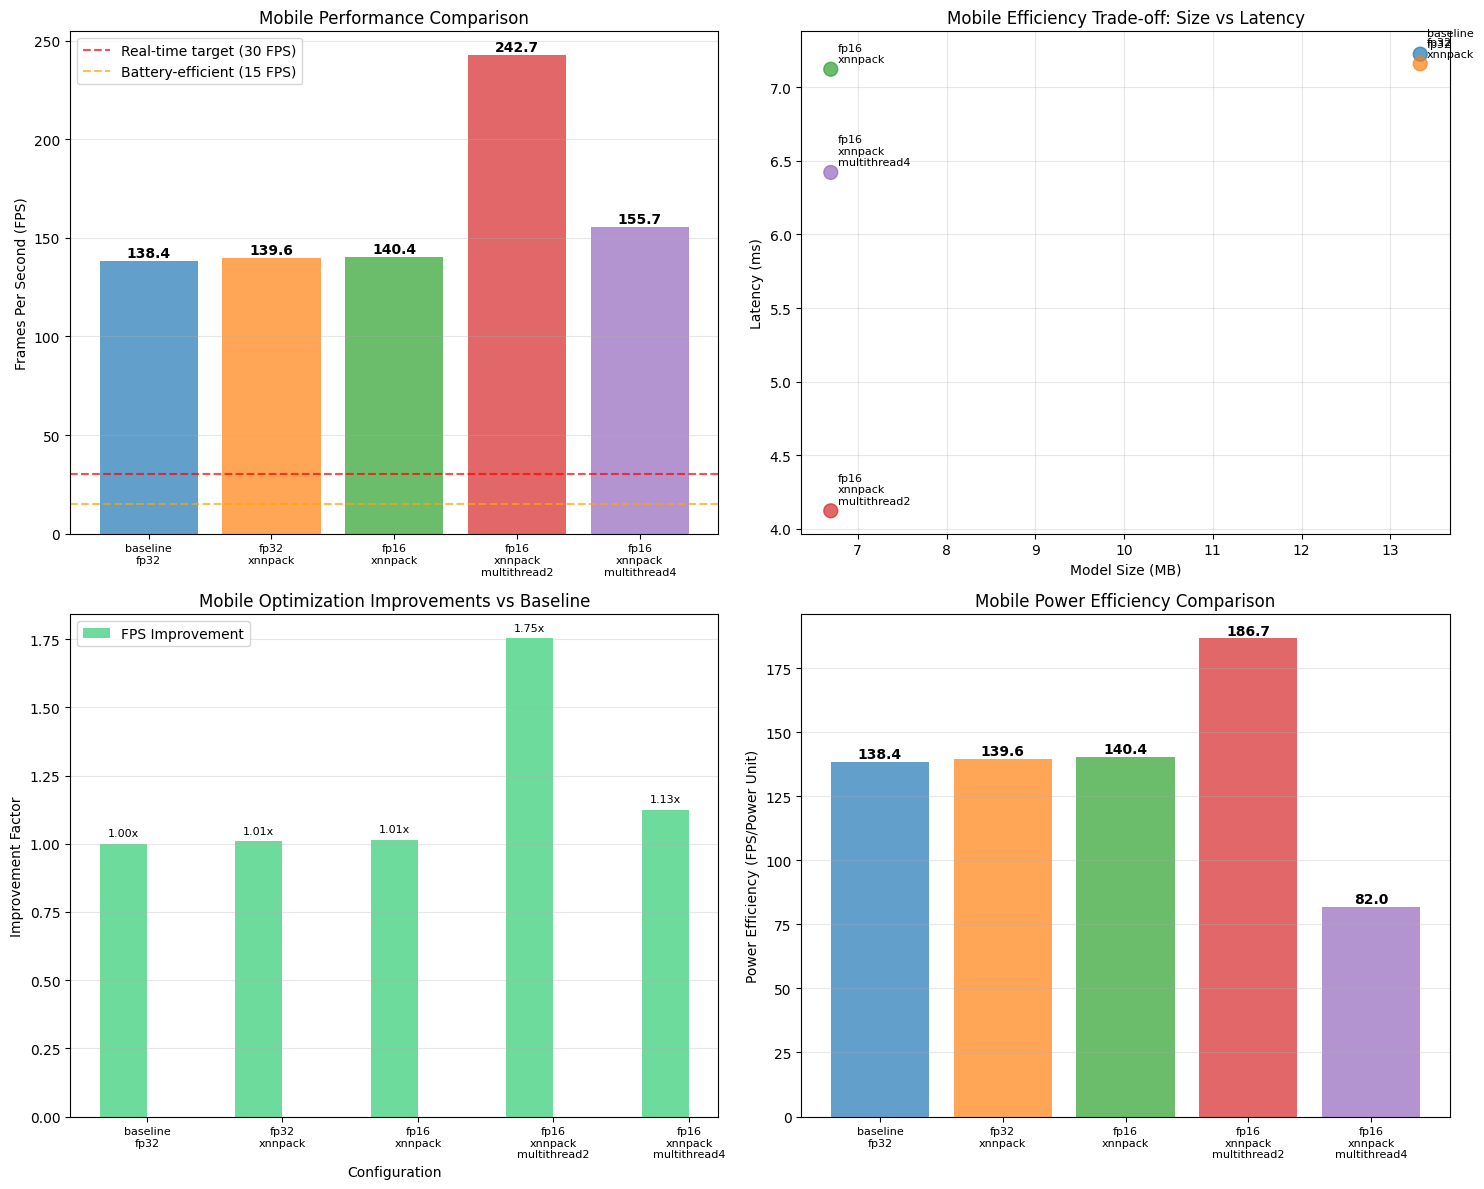


Visualization saved to: assets/exercise2/mobile_optimization_results.png


In [10]:
def visualize_mobile_optimization_results():
    """Create comprehensive visualization of mobile optimization results"""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Extract data for visualization
    config_names = list(benchmark_results.keys())
    fps_values = [benchmark_results[name]['fps'] for name in config_names]
    latency_values = [benchmark_results[name]['avg_latency_ms'] for name in config_names]
    size_values = [benchmark_results[name]['model_size_mb'] for name in config_names]

    # Define colors
    cmap = plt.get_cmap('tab10')
    colors = [cmap(i % 10) for i in range(len(config_names))]
    
    # 1. FPS Comparison
    bars1 = ax1.bar(config_names, fps_values, color=colors, alpha=0.7)
    ax1.set_ylabel('Frames Per Second (FPS)')
    ax1.set_title('Mobile Performance Comparison')
    ax1.axhline(y=30, color='red', linestyle='--', alpha=0.7, label='Real-time target (30 FPS)')
    ax1.axhline(y=15, color='orange', linestyle='--', alpha=0.7, label='Battery-efficient (15 FPS)')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    # Add FPS values on bars
    for bar, fps in zip(bars1, fps_values):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                f'{fps:.1f}', ha='center', va='bottom', fontweight='bold')
    
    # 2. Latency vs Model Size
    ax2.scatter(size_values, latency_values, c=colors, s=100, alpha=0.7)
    for i, name in enumerate(config_names):
        ax2.annotate(name.replace('_', '\n'), (size_values[i], latency_values[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    ax2.set_xlabel('Model Size (MB)')
    ax2.set_ylabel('Latency (ms)')
    ax2.set_title('Mobile Efficiency Trade-off: Size vs Latency')
    ax2.grid(True, alpha=0.3)
    
    # 3. Improvement factors relative to baseline
    baseline_fps = benchmark_results['baseline_fp32']['fps']
    baseline_size = benchmark_results['baseline_fp32']['model_size_mb']
    
    fps_improvements = [fps / baseline_fps for fps in fps_values]
    size_reductions = [(baseline_size - size) / baseline_size * 100 for size in size_values]
    
    x = np.arange(len(config_names))
    width = 0.35
    
    bars3a = ax3.bar(x - width/2, fps_improvements, width, label='FPS Improvement', 
                     color='#2ecc71', alpha=0.7)
    
    ax3.set_xlabel('Configuration')
    ax3.set_ylabel('Improvement Factor')
    ax3.set_title('Mobile Optimization Improvements vs Baseline')
    ax3.set_xticks(x)
    ax3.set_xticklabels([name.replace('_', '\n') for name in config_names], fontsize=8)
    ax3.legend()
    ax3.grid(axis='y', alpha=0.3)
    
    # Add improvement values on bars
    for bar, imp in zip(bars3a, fps_improvements):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                f'{imp:.2f}x', ha='center', va='bottom', fontsize=8)
    
    # 4. Power Efficiency Analysis
    # Calculate power efficiency scores
    power_scores = []
    for config_name in config_names:
        config = benchmark_results[config_name]['config']
        fps = benchmark_results[config_name]['fps']
        num_threads = config.get('num_threads', 1)
        use_xnnpack = config.get('use_xnnpack', False)
        
        # Simplified power model
        base_power = 1.0
        thread_power = base_power * (1 + 0.3 * (num_threads - 1))
        optimization_power = thread_power * (0.8 if use_xnnpack else 1.0)
        power_efficiency = fps / optimization_power
        power_scores.append(power_efficiency)
    
    bars4 = ax4.bar(config_names, power_scores, color=colors, alpha=0.7)
    ax4.set_ylabel('Power Efficiency (FPS/Power Unit)')
    ax4.set_title('Mobile Power Efficiency Comparison')
    ax4.grid(axis='y', alpha=0.3)
    
    # Add efficiency values on bars
    for bar, score in zip(bars4, power_scores):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2, 
                f'{score:.1f}', ha='center', va='bottom', fontweight='bold')
    
    # Rotate x-axis labels for better readability
    for ax in [ax1, ax4]:
        ax.set_xticklabels([name.replace('_', '\n') for name in config_names], 
                          rotation=0, ha='center', fontsize=8)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'mobile_optimization_results.png'), 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nVisualization saved to: {output_dir}/mobile_optimization_results.png")

# Create comprehensive visualization
visualize_mobile_optimization_results()

> **Hardware context matters**: Are you surprised about xnnpack not providing speed-ups? This is expected! These results show server CPU performance, after all. On actual mobile ARM processors:
> 
> - Baseline performance would be ~10x slower
> - XNNPACK would provide 2-3x acceleration
> - Threading benefits would be limited by thermal constraints
> 
> This demonstrates why mobile-specific optimization strategies are essential for deployment.

----

> **TODO**. Test your understanding of mobile optimization strategies.
> 
> Use your benchmark results and your knowledge of model precision, threading, and delegates to complete the tasks below.
> 
> **PART 1: SCENARIO RECOMMENDATIONS**
> For each scenario, choose the LiteRT configuration you think is most appropriate. Justify your choice based on trade-offs such as latency, model size, battery life, accuracy, and device compatibility.
> 
> **1.** Real-time Photo Filter App
> 
> - _Requirements_: Smooth live camera preview (>30 FPS), 2-hour battery life, mid-range Android devices (~2GB RAM).
> - _Constraints_: App size <100MB, fast startup, no accuracy loss.
> - _Your recommended configuration_: `xnnpack_fp16_multithread`
> - _Justification_: FP16 reduces model size for faster startup and lower memory use; XNNPack accelerates CPU inference; moderate multithreading keeps latency low without excessive power drain. This balances real-time performance, battery life, and device compatibility.
> 
> **2.** Offline Travel Photo Assistant
> 
> - _Requirements_: Works offline, prioritizes 7-day battery life, budget phones (~512MB RAM).
> - _Constraints_: Must be very small for emerging markets, occasional slower processing is fine.
> - _Your recommended configuration_: `xnnpack_fp16_singlethread`
> - _Justification_: FP16 minimizes model size for storage-constrained devices; single-threading reduces power usage for long battery life; occasional slower processing is acceptable, so extreme latency optimization isn’t required.
> 
> **3.** Enterprise Document Scanner
> 
> - _Requirements_: High accuracy, sustained performance for 8+ hours, premium flagship devices.
> - _Constraints_: Speed less important than accuracy, power budget available.
> - _Your recommended configuration_: `xnnpack_fp32_singlethread`
> - _Justification_: Accuracy is paramount, so FP32 preserves precision; single-threading ensures predictable, stable performance for sustained use; device resources are premium, so extreme model size reduction or aggressive threading isn’t needed.
> 
> **PART 2: BONUS QUESTIONS**
> 
> **1.** What differences did you observe when changing the number of threads? How might this affect latency stability and power usage?
> <br> _HINT_: Find information at https://ai.google.dev/edge/litert/models/best_practices#tweak_the_number_of_threads 
> <br>_Your answer:_ Increasing threads can reduce average latency up to a point, but too many threads introduce jitter, synchronization overhead, and higher power consumption. Optimal threading depends on CPU architecture and workload.
> 
> **2.** LiteRT uses a delegate hierarchy (CPU → GPU → NPU) rather than forcing all operations onto the fastest available accelerator. Why might this be important for mobile deployment?
> <br>_Your answer_: Using a hierarchy allows LiteRT to map operations to the most suitable hardware based on availability and compatibility. Not all operations are supported on GPU or NPU, and forcing everything to the fastest accelerator could reduce stability, increase power usage, or fail on devices with heterogeneous hardware.

## Conclusion

In this exercise, you have uncovered LiteRT's mobile optimization capabilities by implementing and benchmarking different delegate configurations, threading strategies, and precision optimizations.

**Key insight**: Mobile deployment success depends on matching hardware acceleration strategies to specific app requirements and device constraints. LiteRT's delegate system provides the flexibility to optimize for performance, power efficiency, or broad compatibility without changing your model architecture.

The optimization principles you have learned&mdash;delegate selection, threading configuration, and precision optimization&mdash;apply broadly to mobile AI deployment and are essential for creating responsive, battery-efficient mobile applications.

##### **Next mobile optimization challenges to explore:**

- **Advanced quantization**: Implement INT8 post-training quantization with representative datasets
- **Custom operations**: Create hardware-specific custom operators for specialized mobile workloads
- **Dynamic optimization**: Design runtime performance adaptation based on device capabilities and thermal state